# 5. Combine Results

gg-napari-env

In [27]:
import numpy as np
import pandas as pd
import os 

In [28]:
normalization_quantile = 0.001
chosen_OR_nuc_norm_threshold = 0.75 # was 0.7 
chosen_OR_min_area = 400  
chosen_OR_max_area = 900 
chosen_OR_max_eccentricity = 0.8
chosen_OR_border_threshold = 100 
cyto_norm_threshold = 0.2

In [29]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
raw_data_p14 = [d for d in raw_data_dirs if '14' in d]
raw_data_p14

['20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI',
 '20250523 C P14 T U54-647 Lnc4-546 DAPI',
 '20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI',
 '20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI',
 '20250701 F P14 U34-b3-546 Orco-b4-647 DAPI',
 '20250523 B P14 T 9E88-546 Lnc-647 DAPI']

In [30]:
input = '9E89-b1-546 9E99-B2-647 DAPI'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
input_dir = f'../../../RNA-FISH-raw-data/{input}/'
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)

Using 20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI as input directory
Found 6 czi files in ../../../RNA-FISH-raw-data/20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI/
['20250508 9e89 9e99 sample 6.czi', '20250508 9e89 9e99 sample 1.czi', '20250508 9e89 9e99 sample 3 BAD.czi', '20250508 9e89 9e99 sample 4.czi', '20250508 9e89 9e99 sample 2.czi', '20250508 9e89 9e99 sample 5.czi']


In [31]:
channels = ['AF546', 'AF647']
channel_names = ["9E89", "9E99"]

In [32]:
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('with_overlap.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results_individual = pd.read_csv(results_path)
    results_individual.columns = results_individual.columns.str.split('-T').str[0]
    results = pd.concat([results, results_individual], axis=0) 
results = results.reset_index(drop=True)


# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, normalization_quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
        cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
        results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)
        # Also save the ratio 
        results.loc[results['image'] == image, f'{channel}-cyto-nuc-ratio'] = results.loc[results['image'] == image, f'{channel}-cyto-norm'] / results.loc[results['image'] == image, f'{channel}-nuc-norm']

# Assign "Chosen OR" annotations based on border pixels, nuclear area, and normalized signals 
for channel in channels: 
    results[f'{channel}-cytoplasmic'] = (results['border_pxls'] > chosen_OR_border_threshold) & (results['nucleus_area'] > chosen_OR_min_area) & (results['nucleus_area'] < chosen_OR_max_area) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > chosen_OR_nuc_norm_threshold)

# Drop rows where "BAD" is in the "image" column 
results = results[~results['image'].str.contains('BAD')]

# Save the updated results
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results.to_csv(results_path, index=False)


# Compile results for each channel and melt the dataframes
results_melted = []
for channel in channels: 
    results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

    # Get cytoplasmic cells melted 
    melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area', 'nucleus_eccentricity'], 
                                             value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
    melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
    melted_cyto['cytoplasmic_channel'] = channel

    # Get nucleus cells melted
    melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area', 'nucleus_eccentricity'], 
                                             value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
    melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
    melted_nuc['cytoplasmic_channel'] = channel

    # Merge melted dataframes
    melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area', 'nucleus_eccentricity'], how='outer')

    # Assign names 
    melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
    melted_merged['chosen_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
    melted_merged['chosen_OR_name'] = melted_merged['chosen_OR_name'] + " chosen OR"

    # Save to results_melted 
    results_melted.append(melted_merged)

# Concatenate all melted dataframes
results_melted = pd.concat(results_melted, axis=0)

# Save the melted results 
melted_results_path = os.path.join(results_dir, 'all_results_melted.csv')
results_melted.to_csv(melted_results_path, index=False)

In [33]:
results_melted

,image,z,z_id,border_pxls,nucleus_area,nucleus_eccentricity,channel,cyto-norm,cytoplasmic_channel,nuc-norm,channel_name,chosen_OR_name
0,20250508 9e89 9e99 sample 1.czi,9,39,178,784.0,0.529615,AF546,0.843045,AF546,1.357917,9E89,9E89 chosen OR
1,20250508 9e89 9e99 sample 1.czi,9,39,178,784.0,0.529615,AF647,0.000000,AF546,0.095074,9E99,9E89 chosen OR
2,20250508 9e89 9e99 sample 1.czi,10,48,168,797.0,0.613939,AF546,0.943175,AF546,1.504757,9E89,9E89 chosen OR
3,20250508 9e89 9e99 sample 1.czi,10,48,168,797.0,0.613939,AF647,0.000000,AF546,0.055078,9E99,9E89 chosen OR
4,20250508 9e89 9e99 sample 1.czi,11,65,166,703.0,0.721685,AF546,0.596813,AF546,1.174098,9E89,9E89 chosen OR
...,...,...,...,...,...,...,...,...,...,...,...,...
421,20250508 9e89 9e99 sample 6.czi,110,172,217,487.0,0.407148,AF647,0.299888,AF647,0.752994,9E99,9E99 chosen OR
422,20250508 9e89 9e99 sample 6.czi,110,175,209,491.0,0.379466,AF546,0.022908,AF647,0.431635,9E89,9E99 chosen OR
423,20250508 9e89 9e99 sample 6.czi,110,175,209,491.0,0.379466,AF647,0.205633,AF647,0.881619,9E99,9E99 chosen OR
424,20250508 9e89 9e99 sample 6.czi,111,117,246,725.0,0.381541,AF546,0.029055,AF647,0.373006,9E89,9E99 chosen OR


In [34]:
results.columns

Index(['image', 'z', 'z_id', 'nucleus_area', 'nucleus_eccentricity',
       'centroid_x', 'centroid_y', 'AF546-nucleus-mean',
       'AF546-nucleus-median', 'AF546-nucleus-sum', 'AF647-nucleus-mean',
       'AF647-nucleus-median', 'AF647-nucleus-sum', 'border_pxls',
       'AF546-cyto-mean', 'AF546-cyto-median', 'AF546-cyto-sum',
       'AF647-cyto-mean', 'AF647-cyto-median', 'AF647-cyto-sum',
       'AF546-area-nucleus', 'AF546-area-cytoplasm', 'AF647-area-nucleus',
       'AF647-area-cytoplasm', 'AF546-AF647-overlap-nucleus',
       'AF546-AF647-overlap-cytoplasm', 'AF546-nuc-norm', 'AF546-cyto-norm',
       'AF546-cyto-nuc-ratio', 'AF647-nuc-norm', 'AF647-cyto-norm',
       'AF647-cyto-nuc-ratio', 'AF546-cytoplasmic', 'AF647-cytoplasmic'],
      dtype='object')

<Axes: xlabel='nuc_norm_log', ylabel='Count'>

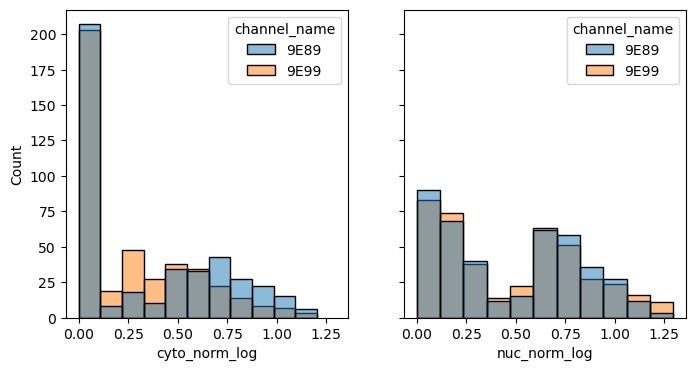

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot density of log-intensities for different channels 
results_melted['cyto_norm_log'] = np.log1p(results_melted['cyto-norm'])
results_melted['nuc_norm_log'] = np.log1p(results_melted['nuc-norm'])
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.histplot(data=results_melted, x='cyto_norm_log', hue='channel_name', fill=True, common_norm=False, alpha=0.5, ax=ax[0])
sns.histplot(data=results_melted, x='nuc_norm_log', hue='channel_name', fill=True, common_norm=False, alpha=0.5, ax=ax[1])

## Run on all images

In [36]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
raw_data_p14 = [d for d in raw_data_dirs if 'P14' in d]
raw_data_p14

['20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI',
 '20250523 C P14 T U54-647 Lnc4-546 DAPI',
 '20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI',
 '20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI',
 '20250701 F P14 U34-b3-546 Orco-b4-647 DAPI',
 '20250523 B P14 T 9E88-546 Lnc-647 DAPI']

In [37]:
for input in raw_data_p14: 

    print(f'Using {input} as input directory')

    if "9E99-b2-594 LOC105286072-B5-647" in input:
        channels = ["AF594", "AF647"]
        channel_names = ["9E99", "LOC105286072"]
    elif "U34-b3-546 Orco-b4-647" in input:
        channels = ["AF546", "AF647"]
        channel_names = ["U34", "Orco"]
    elif "9E197" in input:
        channels = ['AF546', 'AF488', 'AF647']
        channel_names = ["9E197", "9E198", "9E196"]
    elif "9E89-b1-546 9E99-B2-647" in input: 
        channels = ['AF546', 'AF647']
        channel_names = ["9E89", "9E99"]
    elif "Chymotrypsin" in input: 
        channels = ["AF546", "AF647"]
        channel_names = ["U34", "Chymotrypsin"]
    elif "LOC603-b3-488 9E108-b1-546 9E116-b2-647" in input: 
        channels = ['AF546', 'AF488', 'AF647']
        channel_names = ["9E108", "LOC105282603", "9E116"]
    elif "R2-b3-488" in input: 
        channels = ['AF488', 'AF546', 'AF647']
        channel_names = ["R2/3", "Q1", "PR"]
    elif "G1-b1-546 " in input: 
        channels = ["AF546", "AF647"]
        channel_names = ["G1", "LOC113562161"]
    elif "U54-647 Lnc4-546" in input: 
        channels = ["AF546", "AF647"]
        channel_names = ["PR", "U54"]
    elif "9E213-546 9E214-488 Intergenic-647" in input: 
        channels = ["AF546", "AF488", "AF647"]
        channel_names = ["9E213", "9E214", "IPR"]
    elif "U34-B3-488 lnc4-B1-546 U21-B5-647" in input: 
        channels = ["AF488", "AF546", "AF647"]
        channel_names = ["U34", "PR", "U21"]
    elif "Lnc3-b3-488 L16-b2-594 Lnc2-b5-647" in input: 
        channels = ["AF488", "AF594", "AF647"]
        channel_names = ["PR2", "L16", "PR"]
    elif "9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488" in input: 
        channels = ["AF546", "AF647", "AF488"]
        channel_names = ["9E118 Exons", "9E118 Introns", "9E129"]
    elif "9E129-b3-488 LOC104-b1-546 9E116-b2-647" in input: 
        channels = ["AF488", "AF546", "AF647"]
        channel_names = ["9E129", "Kr-h1", "9E116"]
    elif "9E88-546 Lnc-647" in input: 
        channels = ["AF546", "AF647"]
        channel_names = ["9E88", "PR"]
    elif "T79-intergenic-b2-647 T79-exonic-b1-546 DAPI" in input: 
        channels = ["AF546", "AF647"]
        channel_names = ["T79 Exons", "T79 Intergenics"]
    else: 
        raise ValueError(f"Input {input} not recognized. Please check the input directory name.")


    results_dir = f'../results/{input}'
    results_files = os.listdir(results_dir)
    results_files = [f for f in results_files if f.endswith('with_overlap.csv')]

    # Load all results 
    results = pd.DataFrame() 
    for f in results_files:
        results_path = os.path.join(results_dir, f)
        results_individual = pd.read_csv(results_path)
        results_individual.columns = results_individual.columns.str.split('-T').str[0]
        results = pd.concat([results, results_individual], axis=0) 
    results = results.reset_index(drop=True)


    # Normalize the nucleus mean signal for each channel and each image 
    for channel in channels: 
        for image in results['image'].unique(): 
            nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
            lower = np.quantile(nucleus_mean_signal, normalization_quantile)
            upper = np.quantile(nucleus_mean_signal, 1 - normalization_quantile)
            results.loc[results['image'] == image, f'{channel}-nuc-norm'] = (nucleus_mean_signal - lower) / (upper - lower)
            cyto_mean_signal = results.loc[results['image'] == image][f'{channel}-cyto-mean'].values
            results.loc[results['image'] == image, f'{channel}-cyto-norm'] = (cyto_mean_signal - lower) / (upper - lower)
            # Also save the ratio 
            results.loc[results['image'] == image, f'{channel}-cyto-nuc-ratio'] = results.loc[results['image'] == image, f'{channel}-cyto-norm'] / results.loc[results['image'] == image, f'{channel}-nuc-norm']

    # Assign "Chosen OR" annotations based on border pixels, nuclear area, and normalized signals 
    for channel in channels: 
        results[f'{channel}-cytoplasmic'] = (results['nucleus_eccentricity'] < chosen_OR_max_eccentricity) & (results['border_pxls'] > chosen_OR_border_threshold) & (results['nucleus_area'] > chosen_OR_min_area) & (results['nucleus_area'] < chosen_OR_max_area) & (results[f'{channel}-cyto-norm'] > cyto_norm_threshold) & (results[f'{channel}-nuc-norm'] > chosen_OR_nuc_norm_threshold)
    
    # Drop rows where multiple channels are marked as cytoplasmic
    """results['cytoplasmic-count'] = 0 
    for channel in channels:
        results['cytoplasmic-count'] += results[f'{channel}-cytoplasmic'].astype(int)

    # Keep only rows where exactly one channel is marked as cytoplasmic 
    # This helps remove some autofluorescence artifacts (cuticle mostly) that shows up in both channels 
    results = results[results['cytoplasmic-count'] <= 1].reset_index(drop=True)
    """
    
    # Drop rows where "BAD" is in the "image" column 
    results = results[~results['image'].str.contains('BAD')].reset_index(drop=True)

    # Save the updated results
    results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
    results.to_csv(results_path, index=False)

    # Compile results for each channel and melt the dataframes
    results_melted = []
    for channel in channels: 
        results_subset_cytoplasmic = results[results[f'{channel}-cytoplasmic']]

        # Get cytoplasmic cells melted 
        melted_cyto = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area', 'nucleus_eccentricity'], 
                                                value_vars=[c+"-cyto-norm" for c in channels], var_name='channel', value_name='cyto-norm')
        melted_cyto['channel'] = melted_cyto['channel'].str.replace('-cyto-norm', '')
        melted_cyto['cytoplasmic_channel'] = channel

        # Get nucleus cells melted
        melted_nuc = results_subset_cytoplasmic.melt(id_vars=['image', 'z', 'z_id', 'border_pxls', 'nucleus_area', 'nucleus_eccentricity'], 
                                                value_vars=[c+"-nuc-norm" for c in channels], var_name='channel', value_name='nuc-norm')
        melted_nuc['channel'] = melted_nuc['channel'].str.replace('-nuc-norm', '')
        melted_nuc['cytoplasmic_channel'] = channel

        # Merge melted dataframes
        melted_merged = pd.merge(melted_cyto, melted_nuc, on=['image', 'z', 'z_id', 'cytoplasmic_channel', 'channel', 'border_pxls', 'nucleus_area', 'nucleus_eccentricity'], how='outer')

        # Assign names 
        melted_merged['channel_name'] = ""
        melted_merged['channel_name'] = melted_merged['channel'].map(dict(zip(channels, channel_names)))
        melted_merged['chosen_OR_name'] = melted_merged['cytoplasmic_channel'].map(dict(zip(channels, channel_names)))
        melted_merged['chosen_OR_name'] = melted_merged['chosen_OR_name'] + " chosen OR"

        # Save to results_melted 
        results_melted.append(melted_merged)

    # Concatenate all melted dataframes
    results_melted = pd.concat(results_melted, axis=0)

    # Save the melted results 
    melted_results_path = os.path.join(results_dir, 'all_results_melted.csv')
    results_melted.to_csv(melted_results_path, index=False)
            

Using 20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI as input directory
Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory
Using 20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI as input directory
Using 20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI as input directory
Using 20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI as input directory
Using 20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI as input directory
Using 20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI as input directory
Using 20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI as input directory
Using 20250523 C P14 T U54-647 Lnc4-546 DAPI as input directory
Using 20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI as input directory
Using 20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI as input directory
Using 20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI as input directory
Using 20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 